<a href="https://colab.research.google.com/github/drskprabhakar/Axial-Length-Prediction-ML-Regression-mode/blob/main/Improving_10_images_DR_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np

In [2]:
os.listdir('/content/drive/MyDrive/DR fundus images/split')

['train', 'val', 'test']

In [4]:
os.listdir('/content/drive/MyDrive/DR fundus images/split/train')

['DR2', 'DR3', 'DR1']

In [6]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [7]:
train_images = datagen.flow_from_directory('/content/drive/MyDrive/DR fundus images/split/train',
                                               target_size=(64,64),
                                               class_mode='categorical')

validation_images = datagen.flow_from_directory('/content/drive/MyDrive/DR fundus images/split/val',
                                               target_size=(64,64),
                                               class_mode='categorical')

test_images = datagen.flow_from_directory('/content/drive/MyDrive/DR fundus images/split/test',
                                               target_size=(64,64),
                                               class_mode='categorical')


Found 84 images belonging to 3 classes.
Found 11 images belonging to 3 classes.
Found 11 images belonging to 3 classes.


In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dense (Dense)               (None, 128)               6889600   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

In [68]:
history = model.fit(train_images,
          batch_size=32,
          epochs=3,
          validation_data=validation_images)

model.save('DRCNN_model.keras')

Epoch 1/3
3/3 [==============================] - 6s 2s/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 1.3145 - val_accuracy: 0.5455
Epoch 2/3
3/3 [==============================] - 4s 2s/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 1.3666 - val_accuracy: 0.5455
Epoch 3/3
3/3 [==============================] - 5s 2s/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 1.5061 - val_accuracy: 0.4545


In [85]:
predictions = model.predict(test_images)

1/1 [==============================] - 1s 558ms/step


In [86]:
y_pred = np.argmax(predictions, axis=1)

In [80]:
y_true = test_images.classes

In [87]:
from sklearn import metrics
metrics.confusion_matrix(y_true,y_pred)

array([[1, 1, 0],
       [0, 5, 0],
       [1, 0, 3]])

In [88]:
print(metrics.classification_report(y_true,y_pred,
                                    target_names=['DR1','DR2','DR3']))

              precision    recall  f1-score   support

         DR1       0.50      0.50      0.50         2
         DR2       0.83      1.00      0.91         5
         DR3       1.00      0.75      0.86         4

    accuracy                           0.82        11
   macro avg       0.78      0.75      0.76        11
weighted avg       0.83      0.82      0.82        11



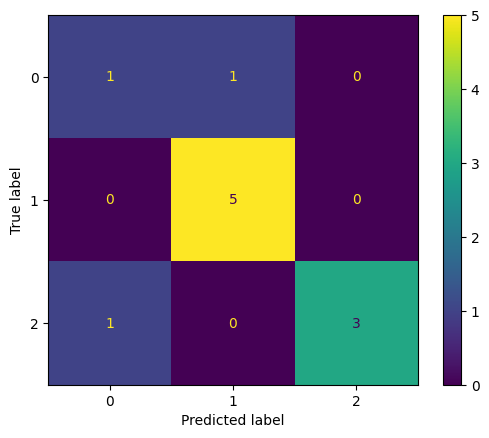

In [89]:
metrics.ConfusionMatrixDisplay.from_predictions(y_true,y_pred)

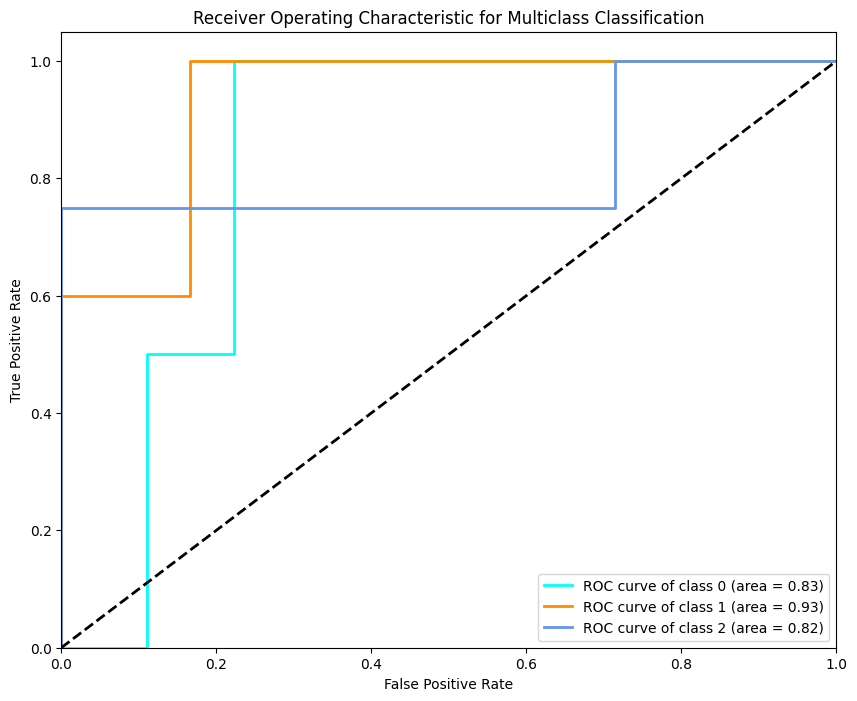

In [90]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import matplotlib.pyplot as plt

# Assuming you have your model predictions and ground truth labels
# model_predictions = Your model's predicted probabilities for each class
# ground_truth_labels = Ground truth labels for each sample

# Convert labels to one-hot encoding
label_binarizer = LabelBinarizer()
ground_truth_labels_binary = label_binarizer.fit_transform(y_true)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_binarizer.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ground_truth_labels_binary[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_binarizer.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 0s 207ms/step
Prediction: DR3


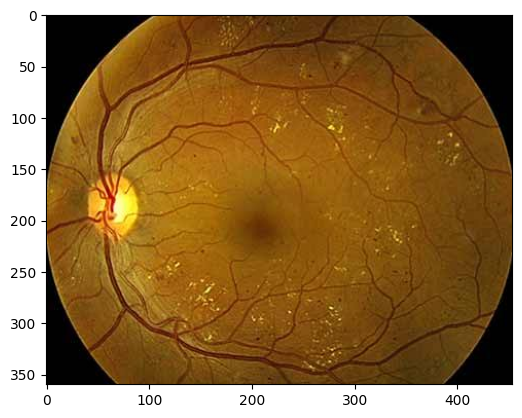

In [91]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained CNN model
model = load_model('/content/DRCNN_model.keras')  # Provide the path to your trained model file

# Define a function to predict unknown images
def predict_unknown_image(image_path):
    img = image.load_img(image_path, target_size=(64,64))  # Assuming images are resized to 150x150
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  # Get the index of the class with the highest probability
    class_names = ["DR1", "DR2", "DR3"]  # Example class names, modify as per your multiclass classes
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

# Example usage:
unknown_image_path = "/content/drive/MyDrive/Severe nPDR"  # Provide the path to the unknown image
prediction = predict_unknown_image(unknown_image_path)
print("Prediction:", prediction)

testimage = image.load_img('/content/drive/MyDrive/Severe nPDR')
plt.imshow(testimage)